In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv', index_col=None, engine='python')

In [3]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engagement['time_stamp'] =  pd.to_datetime(engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# finding the time difference between this period and two period ago - grouping by user
engagement = engagement.assign(Duration=engagement.groupby('user_id').time_stamp.diff(periods=2).fillna(0))

In [6]:
engagement['Duration'] = engagement['Duration'].astype('timedelta64[D]')
engagement.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
Duration             float64
dtype: object

In [7]:
# flagging engaged users - those who logged in three times in a period of less than 7 days 
# Three times can be denoted by the original grouping (two cells up)
engagement['three_in_seven'] = np.where((engagement['Duration']>0) & (engagement['Duration']<=7), 1, 0)

In [8]:
engagement = engagement.drop(['time_stamp', 'visited', 'Duration'], axis=1)
engagement.head()

,user_id,three_in_seven
0,1,0
1,2,0
2,2,0
3,2,0
4,2,0


In [9]:
adopted_users = engagement.groupby('user_id').max()

In [10]:
adopted_users.shape

(8823, 1)

In [11]:
users = pd.read_csv('takehome_users.csv', index_col=None, engine='python')

In [12]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [13]:
# Merging data frames to include the adoption variable
df = pd.merge(users, adopted_users, how='left', left_on='object_id', right_on='user_id')

In [14]:
# Also including a variable on whether the referer was a user that ultimately "adopted" the platform
df = pd.merge(df, adopted_users, how='left', left_on='invited_by_user_id', right_on='user_id', suffixes=('_x', '_y'))

In [15]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,three_in_seven_x,three_in_seven_y
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,1.0


In [16]:
df = df.rename(columns={'three_in_seven_x': 'adopted_user', 'three_in_seven_y': 'invited_by_adopted_user'})

In [18]:
df = df.fillna(0)

In [19]:
sum(df.adopted_user)

1656.0

In [20]:
df = df.drop(['name', 'email', 'invited_by_user_id'], axis=1)

In [21]:
# Changing date columns to be days away from todays day

curr_time = pd.to_datetime("now")

df['creation_time'] =  pd.to_datetime(df['creation_time'], format='%Y-%m-%d %H:%M:%S')
df['last_session_creation_time'] =  pd.to_datetime(df['last_session_creation_time'], format='%Y-%m-%d %H:%M:%S')

df['creating_time_diff'] = curr_time - df['creation_time']
df['last_session_diff'] = curr_time - df['last_session_creation_time']

In [22]:
df['creating_time_diff'] = df['creating_time_diff'].astype('timedelta64[D]')
df['last_session_diff'] = df['last_session_diff'].astype('timedelta64[D]')

In [23]:
df = df.drop(['creation_time', 'last_session_creation_time'], axis = 1)

In [24]:
df = df.join(pd.get_dummies(df.creation_source)).drop("creation_source", axis=1)

In [25]:
df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,invited_by_adopted_user,creating_time_diff,last_session_diff,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,1,0,11,0.0,0.0,1872.0,18054.0,1,0,0,0,0
1,2,0,0,1,1.0,0.0,2030.0,18054.0,0,1,0,0,0
2,3,0,0,94,0.0,1.0,2270.0,18054.0,0,1,0,0,0
3,4,0,0,1,0.0,1.0,2208.0,18054.0,1,0,0,0,0
4,5,0,0,193,0.0,1.0,2332.0,18054.0,1,0,0,0,0


In [26]:
print(sum(df.adopted_user))
len(df) - sum(df.adopted_user)

1656.0


10344.0

In [27]:
#upsampling as our current ratio of 1 to 0 is only .3 
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.adopted_user==0]
df_minority = df[df.adopted_user==1]
 
# Downsample majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=10344,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
 
# Display new class counts
df_upsampled.adopted_user.value_counts()

0.0    10344
1.0    10344
Name: adopted_user, dtype: int64

In [28]:
# Splitting X and y - preparing for log reg

from sklearn.model_selection import train_test_split

X = df_upsampled.drop(['object_id', 'adopted_user'], axis=1)
y = df_upsampled['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.58

Confusion matrix: 
 [[1804 1284]
 [1301 1818]]

Classification report: 
               precision    recall  f1-score   support

         0.0       0.58      0.58      0.58      3088
         1.0       0.59      0.58      0.58      3119

   micro avg       0.58      0.58      0.58      6207
   macro avg       0.58      0.58      0.58      6207
weighted avg       0.58      0.58      0.58      6207



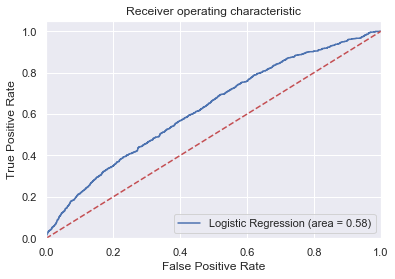

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [31]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.667142
         Iterations: 35
                                     Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.038      
Dependent Variable:         adopted_user            AIC:                     27623.6588 
Date:                       2019-06-07 14:16        BIC:                     27703.0319 
No. Observations:           20688                   Log-Likelihood:          -13802.    
Df Model:                   9                       LL-Null:                 -14340.    
Df Residuals:               20678                   LLR p-value:             6.9940e-226
Converged:                  0.0000                  Scale:                   1.0000     
No. Iterations:             35.0000                                                     
----------------------------------------------------------------------------------------
                            Coef.    Std.Err.     z    P>|z|      [0.025       0.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [32]:
# Removing highly collinear features

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if vif['VIFactor'].max().round(1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max().round(1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max().round(1)
    else:
        print('Complete')
        return df, vif.sort_values('VIFactor').round(1)

final_df, final_vif = iterate_vif(X_train)

Iteration # 1
Removing GUEST_INVITE with VIF of inf
Iteration # 2
Removing last_session_diff with VIF of 113.100000
Iteration # 3


/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing creating_time_diff with VIF of 6.800000
Iteration # 4
Complete


In [33]:
X_train=final_df
X_test = X_test[X_train.columns]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.58

Confusion matrix: 
 [[1707 1381]
 [1233 1886]]

Classification report: 
               precision    recall  f1-score   support

         0.0       0.58      0.55      0.57      3088
         1.0       0.58      0.60      0.59      3119

   micro avg       0.58      0.58      0.58      6207
   macro avg       0.58      0.58      0.58      6207
weighted avg       0.58      0.58      0.58      6207



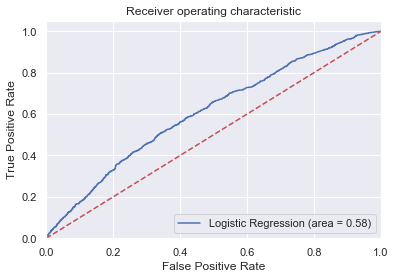

In [34]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [35]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.675906
         Iterations 4
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.025      
Dependent Variable:    adopted_user        AIC:                 19591.5770 
Date:                  2019-06-07 14:16    BIC:                 19652.2218 
No. Observations:      14481               Log-Likelihood:      -9787.8    
Df Model:              7                   LL-Null:             -10037.    
Df Residuals:          14473               LLR p-value:         1.1420e-103
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        4.0000                                              
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
opted_in_to_maili

In [36]:
from sklearn.metrics import roc_auc_score

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 250 decision trees
rf = RandomForestClassifier(random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7841798740628639

In [37]:
conf2 = confusion_matrix(y_test, y_pred2)
conf2

array([[2163,  925],
       [ 412, 2707]])

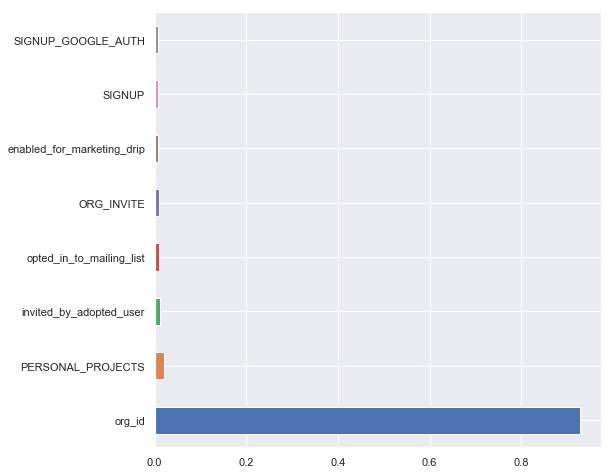

In [38]:
plt.figure(figsize = (8, 8))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [39]:
# With the org_id being such an important variable in the RF model - 
# creating a few intersection variables with this var

df_upsampled['SIGNUP_GOOGLE_AUTH_org_id'] = df_upsampled['SIGNUP_GOOGLE_AUTH'] * df_upsampled['org_id']
df_upsampled['SIGNUP_org_id'] = df_upsampled['SIGNUP'] * df_upsampled['org_id']
df_upsampled['enabled_for_marketing_drip_org_id'] = df_upsampled['enabled_for_marketing_drip'] * df_upsampled['org_id']
df_upsampled['ORG_INVITE_org_id'] = df_upsampled['ORG_INVITE'] * df_upsampled['org_id']
df_upsampled['opted_in_to_mailing_list_org_id'] = df_upsampled['opted_in_to_mailing_list'] * df_upsampled['org_id']
df_upsampled['invited_by_adopted_user_org_id'] = df_upsampled['invited_by_adopted_user'] * df_upsampled['org_id']
df_upsampled['PERSONAL_PROJECTS_org_id'] = df_upsampled['PERSONAL_PROJECTS'] * df_upsampled['org_id']

In [40]:
X = df_upsampled.drop(['object_id', 'adopted_user'], axis=1)
y = df_upsampled['adopted_user']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate model with 250 decision trees
rf = RandomForestClassifier(random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9323383200799873

In [42]:
conf2 = confusion_matrix(y_test, y_pred2)
conf2

array([[1808,  252],
       [  27, 2051]])

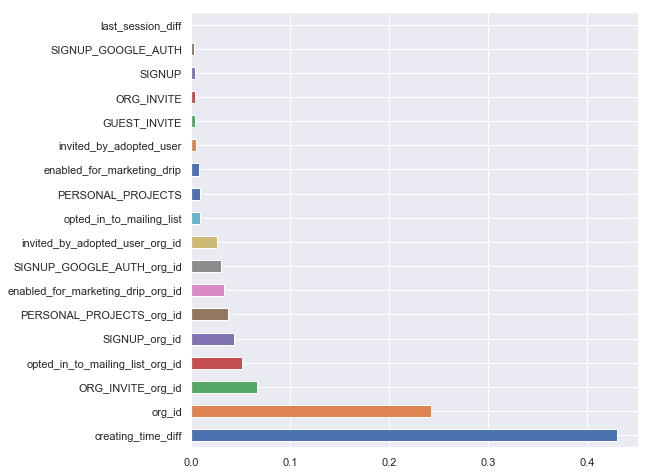

In [43]:
plt.figure(figsize = (8, 8))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Some thoughts:

### * We have been able to identify True Positives and True Negatives with an accuracy of 93% using a Random Forrest Model

### * Some of the leading features in the model include the time difference variable, which was created to tell the longecity of the account as well as the odg_id, which is the identifier of the group in the service to which the user belongs. 

### * It is interesting to see that the cross variables that were created with the org_id also are significant, which further highlights the importance of group belonging to the user adoption.

### * It is surprising that being invited by an adopted user isnt particularly significant as I would have assumed that this would signify a higher likelihood to also adopt a higher use of the service. 


## Further Actions:

### * Tuning of the model could help is upping the accuracy of the model

### * Additonal Features could be made in relation to the time of sign up. Similarly, there could be some further investigation into the "org types" and whether there is some correlation between some types and the more frequent adoption of the service. 

### * it might be useful to break down the org_id into dummies (categories) in order to further distill the actions that one was related to in realtion to that group - for example, we could try and identify those that were invited to the service from a specific group and what that tell us about the subsequent adoption.